# Data Visualisation
This notebook shows visualisations of the various data sources used in this project.

### Contents
- 1 - [Building footprints (OSM)](#buildingFootprints)
- 2 - [Beirut Damage Assessments](#damageAssessment)
    - [GeoPal](#GeoPal)
    - [Beirut Recovery Map](#recoveryMap)
- 3 - [Satellite Imagery](#satelliteImagery)
    - [Sentinel-2](#sentinel2)
    - [Sentinel-1](#sentinel1)
    - [High resolution](#highResolution)
- 4 - [Ground Imagery](#groundImagery)
    - [SARAID Photos](#geopalImagery)
    - [Mapillary](#mapillary)

### Initialisation

In [25]:
# Install packages
#%pip install ee geemap

# Package imports
import math
import json
import requests
import os
#import ee
#import geemap
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from tqdm import tqdm
from ipyleaflet import Map, basemaps, GeoData, CircleMarker, Popup, GeoJSON, LegendControl
from ipywidgets import HTML
from IPython.display import Image, display 

import descarteslabs.workflows as wf

In [2]:
# Define variables
# Location variables
lat, lon, zoom = 33.8975, 35.5063, 14 # Map properties

# Building Footprints variables
buildings = "./data/beirutBuildingFootprints.geojson"

# Damage Assessment variables
dataFile = "./data/geopalData.csv" # GeoPal data
bourjFile = "./data/bourjHammoud.csv"
surveyFile = "./data/SurveyForms.csv"
manualDataFile = "./data/manualDamageClasses.csv"

# Mapillary variables
client_id = 'aGY1d1ZSNFRieTZjempuMHFZc0V6UDowOGE5ODEyZDc0OGJlNzUw' 
bbox = '35.46103477478027,33.87754177691478,35.544376373291016,33.91366258523751'
m_st_date, m_end_date = ['2019-01-01','2020-08-05'],['2020-08-03','2020-12-31']
mapillaryPath = './data/beirutMapillary'

__________________
<a id='buildingFootprints'></a>
## 1 - Building Footprints

Data outlining Building footprints of Beirut. With a Geojson exported from [OSM](https://www.openstreetmap.org/#map=15/33.8994/35.5006), here we plot the data on a map and then display the header of the database to visualise the information it contains.

In [4]:
# Plot on map
m1 = Map(basemap=basemaps.OpenStreetMap.Mapnik, center=[lat, lon], zoom=zoom, scroll_wheel_zoom=True)
with open(buildings, 'r') as f: bfs = json.load(f)
geo_json = GeoJSON(data=bfs,
                   style={'opacity': 1, 'dashArray': '9', 'fillOpacity': 0.5, 'weight': 1},
                   hover_style={'color': 'red', 'dashArray': '0', 'fillOpacity': 0.5})

m1.add_layer(geo_json)

display(m1)
m1.save('./data/footprintsMap.html',title='Beirut Building Footprints') # Save map for quick interaction in HTML

Map(center=[33.8975, 35.5063], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zo…

In [5]:
# Display header 
a = gpd.read_file(buildings)
pd.set_option('display.max_columns', None)
a.head()

,id,@id,building,type,name,addr:city,name:ar,name:en,name:fr,addr:street,alt_name,construction_date,historic,old_name,wikidata,wikipedia,website,building:levels,amenity,tourism,fixme,layer,opening_hours,shop,internet_access,stars,addr:housenumber,addr:postcode,government,office,denomination,religion,wheelchair,created_by,name:de,name:es,note,addr:city:ar,addr:place,addr:place:ar,height,url,contact:phone,healthcare,man_made,addr:country,operator,addr:housename,country,diplomatic,embassy,target,cuisine,source,parking,phone,contact:email,contact:facebook,contact:fax,contact:website,rooms,brand,brand:ar,brand:en,brand:wikidata,brand:wikipedia,takeaway,diplomatic:services:citizen_services,diplomatic:services:immigrant_visas,diplomatic:services:non-immigrant_visas,name:he,craft,addr:street:ar,brand:wikipedia:ar,alt_name:ar,brand:ru,name:ru,email,fax,leisure,contact:mobile,construction,building:part,start_date,level,monument,ruins,atm,disused:railway,fee,internet_access:fee,smoking,roof:shape,name:hy,area,barrier,name_1,name_2,tower:type,contact:instagram,contact:twitter,payment:american_express,payment:cash,payment:cheque,payment:credit_cards,payment:diners_club,payment:mastercard,payment:visa,architect,addr:city:arc,addr:city:syc,emergency,description,historic:civilization,name:zh,landuse,military,fuel:octane_95,fuel:octane_98,delivery,studio,alt_name:en,ele,internet_access:ssid,addr:street:en,healthcare:speciality,operator:type,name_alt,long_name:ar,addr:building,addr:building:fr,addr:city:fr,addr:street:fr,outdoor_seating,castle_type,sport,bus,network,public_transport,access,entrance,supervised,payment:debit_cards,dispensing,clothes,image,diet:meat,opening_hours:covid19,@relations,bicycle,foot,motor_vehicle,highway,crossing,artwork_type,artist_name,geometry
0,relation/71853,relation/71853,yes,multipolygon,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,"POLYGON ((35.4894536 33.8946995, 35.4894132 33..."
1,relation/6678216,relation/6678216,residential,multipolygon,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,"POLYGON ((35.524633 33.8898401, 35.5246194 33...."
2,relation/6996546,relation/6996546,school,multipolygon,Collège des Trois Docteurs,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Non

The map, despite the slightly laggy display due to quantity of data, shows that OSM has excellent building footprint coverage in Beirut. One issue may be the lack of a date on the footprints especiually considering the August 2020 explosion. The table shows that very varied information exists for some buldings but the data is sparse within the detail columns.
- Advantages: Coverage, detailed building outlines, extra building details, freely available
- Limitations: No dates, details sparse for most entries
__________________
<a id='damageAssessment'></a>
## 2 - Beirut Damage Assessment
Data gathered during the damage assessment of the Beirut explosion.
<a id='GeoPal'></a>
### GeoPal
Here we have extracted all the damage assessment information gathered by [SARAID](https://www.saraid.org/) that is accessible through GeoPal. We'll first take a look at the data, then narrow this down to the useful components and finally have a look at spatial distribution.

In [8]:
# View first 5 rows of whole GeoPal data
allData = pd.read_csv(dataFile)
bourj = pd.read_csv(bourjFile)
survey = pd.read_csv(surveyFile)
manual = pd.read_csv(manualDataFile)
pd.set_option('display.max_columns', None) # Show all columns
allData.head()

,Job ID,Job Name,Created By,Created On,Assigned To,Assigned Date Time,Preferred Start,Preferred End,Contact Id,First Name,Last Name,Address Line 1,Address Line 2,Address Line 3,City,Postal Code,Contact Phone Number,Contact Mobile Number,Contact Email,Company Id,Company Name,Start Time,End Time,Last Updated Date Time,Status,Notes,check in - بدء_w_2049197,get location - الموقع_w_2049198,point on map - الموقع على الخريطة_w_2049199,plot number - رقم العقار_w_2049200,plot area - المنطقة العقارية_w_2049201,street - الشارع_w_2049203,building status - وضع البناء_w_2049204,structural damage level - مستوى الضرر الأنشائي للمبنى_w_2049205,must be evacuated? - هل يتوجب إخلاؤه؟_w_2049206,evacuation note - ملاحظة عن ضرورة الإخلاء_w_2049207,number of floors - عدد الطوابق_w_2049208,number of units - عدد الشقق_w_2049209,building use - وجهة الاستعمال للمبنى_w_2049210,ground floor use - وجهة الاستعمال للطابق الأرضي_w_2049211,affected facades - واجهات البناء المتضررة_w_2049212,glass sqm (approximate quantity) - الكمية التقريبية للزجاج_w_2049213,glass and aluminum sqm (approximate quantity) - الكمية التقريبية للألمنيوم و الزجاج_w_2049214,sliding doors sqm (approximate quantity) - الكمية التقريبية للأبواب الجرارة_w_2049215,balconies sqm (approximate quantity) - الكمية التقريبية للشرفات_w_2049216,cladding sqm (approximate quantity) -الكمية التقريبية للتلبيس_w_2049217,external walls sqm (approximate quantity) - الكمية التقريبية للجدران الخارجية_w_2049218,brick pitched roof sqm (approximate quantity) - الكمية التقريبية لتكنة قرميد_w_2049219,others (approximate quantity) - الكمية التقريبية للواجهات الأخرى_w_2049220,heritage building - مبنى تراثي_w_2049221,take pictures - التقاط صور_w_2049222,upload photo_w_2049684,manual report picture_w_2049685,other notes - ملاحظات أخرى_w_2049223,decision - القرار_w_2049224,describe restrictions - وصف القيود_w_2049225,disclaimer_w_2051714,check out - إنهاء_w_2049226,Asset Identifier,Asset Name,Asset Type,Teams,Sites,Time Working,Time Paused,Time Active,Project Identifier,Project Name,Completed And Synced Date Time
0,278,Building Assessment Beirut,Christel Bercachy,11/08/2020 17:54,NaN,NaN,NaN,0000-00-00 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11/08/2020 17:54,NaN,17/08/2020 11:24,JOB_CANCELLED,NaN,11/08/2020 17:54,33.8830089 35.5577379,NaN,123,El Bachoura الباشورة,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://app.geopalsolutions.com/jobs/viewworkf...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00:00:00,00:00:00,00:00:00,NaN,NaN,NaN
1,279,Building Assessment Beirut,Christel Bercachy,11/08/2020 17:57,NaN,NaN,NaN,0000-00-00 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12/08/2020 14:24,NaN,24/08/2020 08:02,JOB_COMPLETED,NaN,12/08/2020 14:24,NaN,NaN,Test,El Bachoura الباشورة,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://app.geopalsolutions.com/jobs/viewworkf...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00:00:00,00:00:00,00:00:00,NaN,NaN,NaN
2,280,Building Assessment Beirut,Christel Bercachy,11/08/2020 18:00,NaN,NaN,NaN,0000-00-00 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11/08/2020 17:59,NaN,17/08/2020 11:21,JOB_CANCELLED,NaN,11/08/2020 17:59,33.8830024 35.5577550,NaN,123,Achrafieh الأشرفية,NaN,Opened on 2020-08-12 10:40:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Opened on 2020-08-12 10:40:15,NaN,62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://app.geopalsolutions.com/jobs/viewworkf...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00:00:00,00:00:00,00:00:00,NaN,NaN,NaN
3,281,Building Assessment Beirut,Christel Bercachy,11/08/2020 18:06,NaN,NaN,NaN,0000-00-00 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11/08/2020 18:06,NaN,17/08/2020 11:20,JOB_CANCELLED,NaN,11/08/2020 18:06,33.8830063 35.5577587,NaN,123,Achrafieh الأشرفية,Achrafieh,Opened on 2020-08-11 20:07:31,Partially destroyed (poses a public safety haz...,Yes نعم,NaN,5.0,5.0,"Residential سكني,Commercial تجاري",Commercial تجاري,Opene

In [9]:
# Extract useful information
# Extract locations from joint column in database 
def get_coords(locations, mapPoints):
    lats, lons = np.zeros([len(locations), 1]),  np.zeros([len(locations), 1])
    for i in range(len(locations)):
        loc = locations[i]
        if type(loc) is float or (type(loc) is str and loc[0].isalpha()):
            mp = mapPoints[i]
            if type(mp) is str and mp[0].isdigit():
                try: lats[i], lons[i] = mp.split(' ')[0], mp.split(' ')[1]
                except: lats[i], lons[i] = mp.split(',')[0], mp.split(',')[1] # Deal with rogue commas instead of space
        else: lats[i], lons[i] = loc.split(' ')[0], loc.split(' ')[1]
    return lats, lons

lats, lons = get_coords(allData['get location - الموقع_w_2049198'], allData['point on map - الموقع على الخريطة_w_2049199'])
# Extract columns of useful data
dataBeirut = pd.DataFrame({
    'id': allData['Job ID'],
    'area': allData['plot area - المنطقة العقارية_w_2049201'],
    'damage': allData['structural damage level - مستوى الضرر الأنشائي للمبنى_w_2049205'],
    'floors': allData['number of floors - عدد الطوابق_w_2049208'],
    'units': allData['number of units - عدد الشقق_w_2049209'],
    'use': allData['building use - وجهة الاستعمال للمبنى_w_2049210'],
    'photos': allData['take pictures - التقاط صور_w_2049222'],
    'decision': allData['decision - القرار_w_2049224']    
})

# Create geodatabase merging locations with useful data
assBeirut = gpd.GeoDataFrame(dataBeirut, geometry=gpd.points_from_xy(lons, lats))

lats, lons = get_coords(bourj['get location - الموقع_w_2048240'], bourj['point on map - الموقع على الخريطة_w_2048241'])
dataBourj = pd.DataFrame({
    'id': bourj['Job ID'],
    'area': bourj['plot area - المنطقة العقارية_w_2048243'],
    'damage': bourj['damage level - مستوى الضرر_w_2048246'],
    'floors': bourj['number of floors - عدد اطوابق_w_2048249'],
    'units': bourj['number of units - عدد الشقق_w_2048250'],
    'use': bourj['building use - وجهة الاستعمال للمبنى_w_2048409'],
    'photos': bourj['take pictures - التقاط صور_w_2048261'],
    'decision': bourj['decision - القرار_w_2048411']    
})
assBourj = gpd.GeoDataFrame(dataBourj, geometry=gpd.points_from_xy(lons, lats))

assessments2 = assBeirut.append(assBourj, ignore_index=True)
assessments =  assessments2.append(gpd.GeoDataFrame(manual['decision'], geometry=gpd.points_from_xy(manual['Lon'], manual['Lat'])), ignore_index=True)

located = assessments[assessments.geometry.x != 0]
located

,id,area,damage,floors,units,use,photos,decision,geometry
0,278,El Bachoura الباشورة,NaN,NaN,NaN,NaN,https://app.geopalsolutions.com/jobs/viewworkf...,NaN,POINT (35.5577379 33.8830089)
2,280,Achrafieh الأشرفية,NaN,NaN,NaN,NaN,https://app.geopalsolutions.com/jobs/viewworkf...,NaN,POINT (35.557755 33.8830024)
3,281,Achrafieh الأشرفية,Partially destroyed (poses a public safety haz...,5.0,5.0,"Residential سكني,Commercial تجاري",NaN,NaN,POINT (35.5577587 33.8830063)
5,283,Achrafieh الأشرفية,Partially destroyed (poses a public safety haz...,4.0,5.0,"Residential سكني,Commercial تجاري",https://app.geopalsolutions.com/jobs/viewworkf...,YELLOW (restricted use) أصفر (لا يصلح للسكن),POINT (35.5577435 33.8830157)
6,284,Achrafieh الأشرفية,Partially destroyed (poses a public safety haz...,4.0,8.0,"Residential سكني,Commercial تجاري",https://app.geopalsolutions.com/jobs/viewworkf...,YELLOW (restricted use) أصفر (لا يصلح للسكن),POINT (35.5577312 33.8829998)
...,...,...,...,...,...,...,...,...,...
11188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,YELLOW,POINT (35.52849000000001 33.90049)
11189,NaN,NaN,NaN,NaN,NaN,NaN,NaN,YELLOW,POINT (35.53178 33.9012)
11190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,YELLOW,POINT (35.53100999999999 33.90117)
11191,NaN,NaN,NaN,NaN,NaN,NaN,NaN,YELLOW,POINT (35.52803 33.89748)


In [10]:
## Plot data on map
# Create Map
m2 = Map(basemap=basemaps.OpenStreetMap.Mapnik, center=[lat, lon], zoom=zoom, scroll_wheel_zoom=True)

# Assign colours according to decision
color_dict = {'GREEN (inspected) أخضر (تم دراسته)': 'green', 'GREEN':'green', 'YELLOW (restricted use) أصفر (لا يصلح للسكن)': 'Yellow', 'YELLOW': 'Yellow', 'RED (unsafe/evacuate) أحمر (غير آمن/للاخلاء)ء': 'red', 'RED':'red', np.nan: 'blue'}
located['color'] = [color_dict[i] for i in located.decision]

# Create marker for each point
for i in tqdm(located.index):
    a = located.loc[i]
    location = (a.geometry.y,a.geometry.x)
    marker = CircleMarker(location=location, radius = 3, color=a.color, fill_color=a.color, fill_opacity=0.8, opacity=0.6)

    # Popup associated to a layer
    msg = HTML()
    if not a.damage is np.nan:
        msg.value = ("Job ID: {}<br>"
                     "Area: {}<br>"
                     "Damage: {}<br>"
                     "Floors: {}<br>"
                     "Units: {}<br>"
                     "Use: {}<br>"
                     "Photos:{}<br>").format(a.id,a.area,a.damage,a.floors,a.units,a.use,' None' if a.photos=='nan' else '<a href='+str(a.photos)+'> Click Link</a>')
    marker.popup = msg
    m2.add_layer(marker)

if not 'l2' in globals(): # Add legend if forming map for first time
    l2 = legend = LegendControl({"No Restrictions":"#008000", "Restricted Use":"#FFFF00", "Unsafe/Evacuated":"#FF0000", "No Decision":"#0000FF"}, name="Decision", position="bottomleft")
    m2.add_control(l2)
    
m2.save('./data/allGeopalMap.html', title='GeoPal Map') # Save map for quick interaction in HTML
m2

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
100%|██████████| 9727/9727 [09:46<00:00, 16.59it/s]


Map(center=[33.8975, 35.5063], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zo…

The GeoPal data has an excellent aspect of Green/Yellow/Red classification for damage/safety of buildings which considers both the structural integrity and safety to the population which is exactly what we are looking for in a Search & Rescue application.
- Advantages: Detailed assessment, G/Y/R classification
- Limitatins: Coverage both due to non-assessment and 465 unlocated assessments
<a id='recoveryMap'></a>
### Beirut Recovery Map data
Here we import data used in the Rice University [Beirut Recovery Map](https://beirutrecovery.org/) interactive tool. The data sources are the following:
- [Beirut FER](https://gis.army.gov.lb/lm/index.php/view/map/?repository=15&project=open) - most complete, we need to request access somehow
- [NASA ARIA](https://www.jpl.nasa.gov/images/aria-damage-map-beirut-explosion-aftermath) - inferred from Sentinel-1 data, see [Sentinel-1 section](#sentinel1)
- [Lebanese Red Cross](https://www.redcross.org.lb/) - incomplete
- Impressive 3D building data - principally based on [Salim Alkadi's model](http://www.salimalkadi.com/07_beirut-001) which can be viewed in [Rhinoceros](https://www.rhino3d.com/) software

_____________
<a id='satelliteImagery'></a>
## 3 - Satellite Imagery
Let's now look at available satellite imagery for before/after the beirut explosion. You'll need the magic markers beneath the maps to scale the images.

In [6]:
# Define function for retrieving satellite imagery from Descartes platform and displaying on map
def getImage(satellite,bands,st_date,end_date,time,opacity=1,mapNum=m1,cloudFraction=0.1):
    img = wf.ImageCollection.from_id(satellite,start_datetime=st_date[time], end_datetime=end_date[time])
    if 'sentinel-2' in satellite: # Use sentinel cloud-mask band if available
        img = img.filter(lambda img: img.properties["cloud_fraction"] <= cloudFraction)
        img = img.map(lambda img: img.mask(img.pick_bands('cloud-mask')==1))
    mos = (img.mosaic().pick_bands(bands))
    globals()['mos_'+str(time+1)+str(bands)] = mos
    display = mos.visualize('Image '+str(time+1)+str(bands), map=mapNum)
    display.opacity = opacity

<a id='sentinel2'></a>
### Sentinel-2

In [7]:
# Initialise map
m4 = wf.interactive.MapApp()
m4.center, m4.zoom = (lat, lon), zoom

satellite, bands, cloudFraction = "sentinel-2:L1C", ['red','green','blue'], 0.03
st_date, end_date = ['2020-07-24T00:00:00.000Z', '2020-08-18T00:00:00.000Z'], ['2020-07-24T14:00:00.000Z', '2020-08-18T14:00:00.000Z'] # Timeframes for before-after imagery: start 1, start 2; end 1 ,end 2

# Loop over dates (time 1 & time 2)
for i in range(len(st_date)):
    getImage(satellite, bands, st_date, end_date, i, 1, m4, cloudFraction)

m4


`ipyleaflet` and/or `ipywidgets` Jupyter extensions are not installed! (or you're not in a Jupyter notebook.)
To install for JupyterLab, run this in a cell:
    !jupyter labextension install jupyter-leaflet @jupyter-widgets/jupyterlab-manager
To install for plain Jupyter Notebook, run this in a cell:
    !jupyter nbextension enable --py --sys-prefix ipyleaflet
Then, restart the kernel and refresh the webpage.


This map shows Sentinel-2 provides cloud free before/after imagery from 24th July and 18th August 2020. Sentinel-2 contains 13 bands with resolution varying from 10m to 60m. See [Copernicus website](https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi/resolutions/spatial) or [Descartes catalog](https://catalog.descarteslabs.com/?/product/sentinel-2:L1C) for full details.
<a id='sentinel1'></a>
### Sentinel-1

In [27]:
# Initialise map
m5 = wf.interactive.MapApp()
m5.center, m5.zoom = (lat, lon), zoom

satellite, bands = "sentinel-1:GRD", ['vh','vv']
st_date, end_date = ['2020-07-30T00:00:00.000Z', '2020-08-05T00:00:00.000Z'], ['2020-07-30T14:00:00.000Z', '2020-08-05T14:00:00.000Z'] # Timeframes for before-after imagery: start 1, start 2; end 1 ,end 2

# Loop over dates (time 1 & time 2)
for i in range(len(st_date)):
    getImage(satellite, bands, st_date, end_date, i, 1, m5)
    for j in bands:
        getImage(satellite, j, st_date, end_date, i, 1, m5)

m5


`ipyleaflet` and/or `ipywidgets` Jupyter extensions are not installed! (or you're not in a Jupyter notebook.)
To install for JupyterLab, run this in a cell:
    !jupyter labextension install jupyter-leaflet @jupyter-widgets/jupyterlab-manager
To install for plain Jupyter Notebook, run this in a cell:
    !jupyter nbextension enable --py --sys-prefix ipyleaflet
Then, restart the kernel and refresh the webpage.


Sentinel-1 has clear before/after radar imagery from 30th July and 5th August 2020. Sentinel-1 contains 2 bands (vv & vh) with 20m resolution. See [Copernicus website](https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-1-sar) or [Descartes catalog](https://catalog.descarteslabs.com/?/product/sentinel-1:GRD) for full details.
<a id='highResolution'></a>
### High Resolution Imagery
Firstly PlanetLabs SkySat have a very limited amount of high resolution imagery available on Google Earth Engine, shown in the next 3 figures, from prior to the explosion:
- [SkySat RGB](https://code.earthengine.google.com/6f8de4d7a3f11a4caffe73d61372716b) - 0.8m resolution
- [SkySat Panchromatic](https://code.earthengine.google.com/4470ae2335bc561c12a4824e72e4fb87) - 0.8m resolution
- [SkySat Multispectral](https://code.earthengine.google.com/2b11bfafc355dfa68b313b1622149fba) - 1m resolution

We do not have high-resolution imagery available for after the explosion so the use of these by themselves may be limited. Will high resolution imagery be available in the immediate aftermath of disasters, or would rights issues hinder progress?
We should ask ESA about availability of high-resolution mapping in immediate aftermath of disasters within [Copernicus EMS](https://emergency.copernicus.eu/).

In [44]:
# RGB Map
hrMap1 = geemap.Map()
dataset = ee.ImageCollection('SKYSAT/GEN-A/PUBLIC/ORTHO/RGB')
rgb = dataset.select(['R', 'G', 'B']);
rgbVis = {min: 11.0, max: 190.0}
hrMap1.setCenter(35.5063, 33.8975, 14)
hrMap1.addLayer(rgb, rgbVis, 'RGB')
display(hrMap1)

Map(center=[33.8975, 35.5063], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButto…

In [48]:
# Panchromatic Map
hrMap2 = geemap.Map()
dataset = ee.ImageCollection('SKYSAT/GEN-A/PUBLIC/ORTHO/MULTISPECTRAL')
falseColor = dataset.select(['P'])
falseColorVis = {min: 200, max: 6000}
hrMap2.setCenter(35.5063, 33.8975, 14)
hrMap2.addLayer(falseColor, falseColorVis, 'False Color')
display(hrMap2)

Map(center=[33.8975, 35.5063], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButto…

In [54]:
# Multispectral Map
hrMap3 = geemap.Map()
dataset = ee.ImageCollection('SKYSAT/GEN-A/PUBLIC/ORTHO/MULTISPECTRAL')
falseColor = dataset.select('N')
falseColorVis = {min: 200, max: 6000}
hrMap3.setCenter(35.5063, 33.8975, 14)
hrMap3.addLayer(falseColor, falseColorVis, 'False Color')
display(hrMap3)

Map(center=[33.8975, 35.5063], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButto…

______________
<a id='groundImagery'></a>
## 4 - Ground Imagery
<a id='geopalImagery'></a>
### SARAID Imagery from GeoPal

In [ ]:
located.head()

<a id='mapillary'></a>
### Mapillary
Let's now try importing from Mapillary. First we'll get a map showing imagery locations before and after the explosion. Secondly we'll get a sample image.

In [11]:
# First we download all the image locations and properties for our area and dates of interest
def to_geodata(filename, color):
    images = gpd.read_file(filename)
    timedImages = GeoData(geo_dataframe = images,
                          style={'color': color, 'radius':2, 'fillColor': color, 'opacity':0.2, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.2},
                          hover_style={'fillColor': 'white' , 'fillOpacity': 0.2},
                          point_style={'radius': 3, 'color': color, 'fillOpacity': 0.2, 'fillColor': color, 'weight': 3},
                          name = 'Images')
    return timedImages

for i in range(len(m_st_date)):
    filename = mapillaryPath+m_st_date[i]+'-'+m_end_date[i]+'.geojson'
    
    if not os.path.exists(filename):  
        # create an empty GeoJSON to collect all images we find
        output = {"type":"FeatureCollection","features":[]}
        with open(filename, 'w') as outfile:
            # Make API call for images within dates
            url = ('https://a.mapillary.com/v3/images?client_id={}&bbox={}&start_time={}&end_time={}&per_page=1000').format(client_id,bbox,m_st_date[i],m_end_date[i]) 
            r = requests.get(url, timeout=None) # get the request with no timeout in case API is slow
            while r.status_code != 200: r = requests.get(url, timeout=None) # check if request failed, if failed, keep trying - 200 is a success

            # Get first data in to output json
            data = r.json() # get a JSON format of the response
            data_length = len(data['features']) # get a count of how many images 
            for feature in data['features']: output['features'].append(feature) # append each image to our empty geojson

            # if we receive 500 items, response was full and should be a next page
            while data_length == 1000:

                link = r.links['next']['url'] # get the URL for a next page
                r = requests.get(link) # retrieve the next page in JSON format
                while r.status_code != 200: r = requests.get(url, timeout=None) # try again if the request fails

                data = r.json()
                for feature in data['features']: output['features'].append(feature)

                print('Total images: {}'.format(len(output['features']))) # print total count
                data_length = len(data['features']) #update data length

            # save the entire JSON response as a geojson for outside use
            json.dump(output, outfile)
     
    if not i: preImages = to_geodata(filename,'green')
    else: postImages = to_geodata(filename, 'red')

In [14]:
# Let's take a quick look at the format of the images
preImages.geo_dataframe.head()

,ca,camera_make,camera_model,captured_at,key,pano,sequence_key,user_key,username,quality_score,organization_key,private,geometry
0,0.000000,Apple,iPhone XR,2020-04-27T16:28:02,lRaJxclrODcjdPj4Q07zbg,False,8cu6lqmeh9avh4eolkusld,ANHxhrNI7u3GxCpl19mbeQ,ziadg,5,None,None,POINT (35.5320788 33.8864233)
1,30.863913,Apple,iPhone XR,2020-04-27T16:28:01,KTehUzug09w__Ctz8dGmbg,False,8cu6lqmeh9avh4eolkusld,ANHxhrNI7u3GxCpl19mbeQ,ziadg,5,None,None,POINT (35.5320788 33.8864233)
2,35.477667,Apple,iPhone XR,2020-04-27T16:28:00,QV2tOLuwn0cEidV0kzx4JA,False,8cu6lqmeh9avh4eolkusld,ANHxhrNI7u3GxCpl19mbeQ,ziadg,3,None,None,POINT (35.5319948 33.8863067)
3,36.101565,Apple,iPhone XR,2020-04-27T16:27:59,ZQflQMWUnPRIsCebag-yCA,False,8cu6lqmeh9avh4eolkusld,ANHxhrNI7u3GxCpl19mbeQ,ziadg,3,None,None,POINT (35.5318928 33.8861879)
4,34.715559,Apple,iPhone XR,2020-04-27T16:27:58,Gw7EbQF4ccIK7h8_CTM6Ng,False,8cu6lqmeh9avh4eolkusld,ANHxhrNI7u3GxCpl19mbeQ,ziadg,5,None,None,POINT (35.5317895 33.8860703)


In [65]:
# Quick Map just showing locations - go to next for full marker map
m6 = Map(basemap=basemaps.OpenStreetMap.Mapnik, center=[lat, lon], zoom=zoom, scroll_wheel_zoom=True)
m6.add_layer(preImages)
m6.add_layer(postImages)
if not 'l6' in globals(): # Add legend if forming map for first time
    l6 = legend = LegendControl({"Pre Explosion":"#008000", "Post Explosion":"#FF0000"}, name="Image Locations", position="bottomleft")
    m6.add_control(l6)

m6

Map(center=[33.8975, 35.5063], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zo…

In [69]:
# Create Map with interactive markers - this will take ages, try the HTML version from the Google Drive
m7 = Map(basemap=basemaps.OpenStreetMap.Mapnik, center=[lat, lon], zoom=zoom, scroll_wheel_zoom=True)

# Create marker for each point
for j in [preImages, postImages]:
    images = j.geo_dataframe
    color = 'green' if j is preImages else 'red'
    for i in tqdm(images.index):
        a = images.loc[i]
        location = (a.geometry.y,a.geometry.x)
        marker = CircleMarker(location=location, radius = 3, color=color, fill_color=color, 
                              fill_opacity=0.8, opacity=0.6)

        # Popup associated to a layer
        msg = HTML()
        msg.value = ("Date: {}<br>"
                     "Quality: {}<br>"
                     "Pano: {}<br>"
                     "Camera:{}<br>"
                     "Key: {}<br>").format(a.captured_at,a.quality_score,a.pano,a.camera_model,a.key)
        marker.popup = msg
        m7.add_layer(marker)

if not 'l7' in globals(): # Add legend if forming map for first time
    l7 = legend = LegendControl({"Pre Explosion":"#008000", "Post Explosion":"#FF0000"}, name="Image Locations", position="bottomleft")
    m7.add_control(l7)

display(m7)
m7.save('./data/mapillaryImagesMap.html', title='Mapillary Map') # Save map for quick interaction in HTML

100%|██████████| 12475/12475 [1:11:29<00:00,  2.91it/s]


Map(center=[33.8975, 35.5063], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zo…

https://images.mapillary.com/GJxrJds217zX2offqGr7EA/thumb-1024.jpg image key: GJxrJds217zX2offqGr7EA


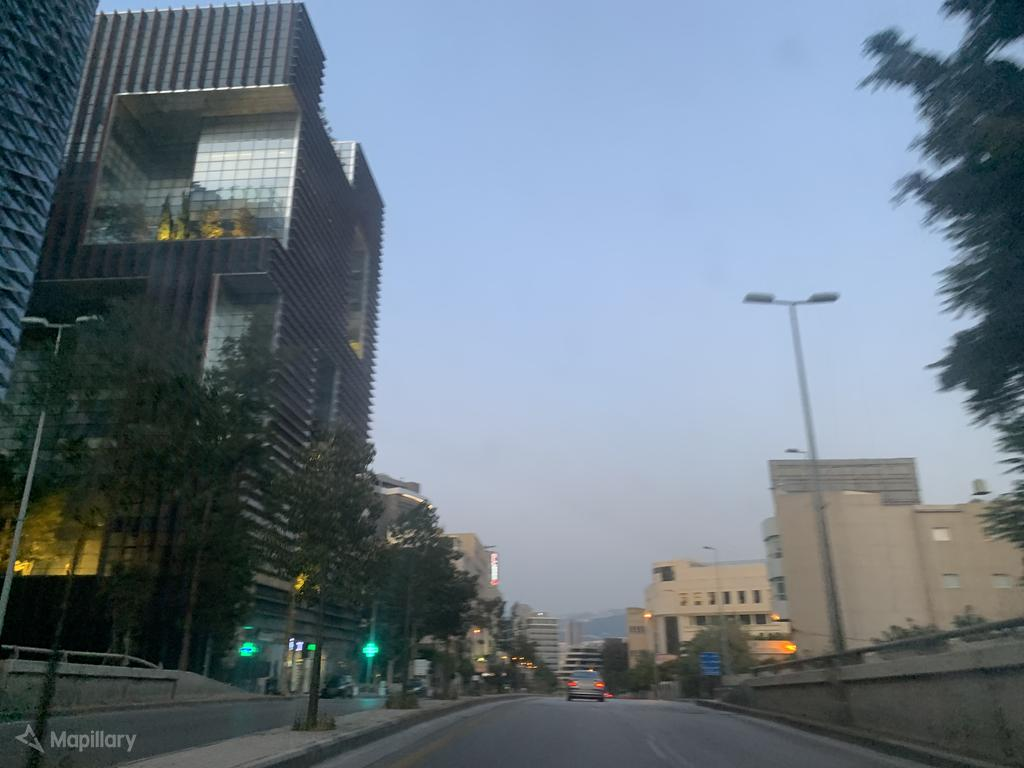

In [21]:
# Display Mapillary Image by defining index or image_key
image_index = 100 # Define Index
image_key = False # Or replace this directly with key found on map
link = 'https://images.mapillary.com/{}/thumb-1024.jpg'.format(preImages.geo_dataframe.loc[image_index].key if not image_key else image_key)
print(link, 'image key: {}'.format(preImages.geo_dataframe.loc[image_index].key if not image_key else image_key))

# request the image URL, to get a displayable image
display(Image(requests.get(link,stream=all).content))

_______________
## 5 - Houston Data

In [30]:
from PIL import Image
im = Image.open('./data/2018IEEE_Contest/Phase2/FullHSIDataset/20170218_UH_CASI_S4_NAD83.pix')
plt.imshow(np.array(im))
plt.title('HR Imagery')
# plt.colorbar()

UnidentifiedImageError: cannot identify image file './data/2018IEEE_Contest/Phase2/FullHSIDataset/20170218_UH_CASI_S4_NAD83.pix'